In [2]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import os
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
import ROOT

C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/opt/conda/bin/../lib/gcc/x86_64-conda-linux-gnu/12.3.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~
input_line_35:1:10: fatal error: 'dlfcn.h' file not found
#include "dlfcn.h"
         ^~~~~~~~~


In [3]:
# Set matplotlib color cycle
new_color_cycle = [

#data
#   '#3232ff', 
#zerobias
    '#002a75',
#passedHLT
    '#00cdcd',
#A14N23LO
    '#b45f06',
#HAHMggf
    '#ff0000',
#HHbbttHadHad
    '#5b0f00',
#jjJZ2
  '#d201d2',
#jjJZ4
    '#4f2ca8',
#Zprime2EJs
    '#00de00',
#qqa
    '#d4d400',
#ZZ4lep
    '#294a18',
#jjJz24
    '#8e1d55',
#test 2
    '#7f7f7f'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [4]:
# This is the list that will hold all of the data (data22 and MC)
datasets = {}
pass_HLT = {}
pass_L1 = {}
weights = {}

## Collect Data

In [5]:
# Read EB Data file
with h5py.File('/home/jovyan/EB_data/AOD_EB_ntuples_05-22-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]


# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)
  

# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

# Indices of events that passed HLT
pass_HLT_idxs = (pass_HLT_unprescaled == 1)

# Append to datasets
datasets['HLT_data'] = HLT_objects[pass_L1_idxs] 
weights['HLT_data'] = EB_weights[pass_L1_idxs]
pass_L1['HLT_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['HLT_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_data'] = L1_objects[pass_L1_idxs]
weights['L1_data'] = EB_weights[pass_L1_idxs]
pass_L1['L1_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['L1_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['HLT_zerobias'] = HLT_objects[~pass_L1_idxs] 
weights['HLT_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['HLT_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['HLT_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['L1_zerobias'] = L1_objects[~pass_L1_idxs]
weights['L1_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['L1_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['L1_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['HLT_passedHLT'] = HLT_objects[pass_HLT_idxs] 
weights['HLT_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['HLT_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['HLT_passedHLT'] = pass_HLT_idxs[pass_HLT_idxs]

datasets['L1_passedHLT'] = L1_objects[pass_HLT_idxs]
weights['L1_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['L1_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['L1_passedHLT'] = pass_HLT_idxs[pass_HLT_idxs]

In [6]:
# Read MC data. 
data_path = '/home/jovyan/MC_data/'
for filename in os.listdir(data_path): 
    if filename.startswith('HLT') or filename.startswith('.'): continue 
    dataset_tag = filename.split('_')[0] 
    with h5py.File(data_path+filename, 'r') as hf: 
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, [0, 2, 3]], HLT_muons[:, :3, [0, 2, 3]], HLT_photons[:, :3, [0, 2, 3]], HLT_MET[:, :, [0, 2, 3]]], axis=1)
        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)

        
        datasets['HLT_'+filename] = HLT_objects[0:min(len(HLT_objects), 100000)]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(HLT_objects), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(HLT_objects), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(HLT_objects), 100000))

        datasets['L1_'+filename] = L1_objects
        weights['L1_'+filename] = np.ones(len(L1_objects))
        pass_L1['L1_'+filename] = pass_L1_idxs
        pass_HLT['L1_'+filename] = pass_HLT_idxs

In [7]:
#create combo of jjJZ4 & jjJZ2 called dijet
datasets['HLT_jjJZ2&jjJZ4'] = np.concatenate((datasets['HLT_jjJZ2_04-24-2024.h5'],datasets['HLT_jjJZ4_04-24-2024.h5']))
weights['HLT_jjJZ2&jjJZ4'] = np.concatenate((weights['HLT_jjJZ2_04-24-2024.h5'],weights['HLT_jjJZ4_04-24-2024.h5']))
pass_L1['HLT_jjJZ2&jjJZ4jjJZ4'] = np.concatenate((pass_L1['HLT_jjJZ2_04-24-2024.h5'],pass_L1['HLT_jjJZ4_04-24-2024.h5']))
pass_HLT['HLT_jjJZ2&jjJZ4'] = np.concatenate((pass_HLT['HLT_jjJZ2_04-24-2024.h5'],pass_HLT['HLT_jjJZ4_04-24-2024.h5']))

datasets['L1_jjJZ2&jjJZ4'] = np.concatenate((datasets['L1_jjJZ2_04-24-2024.h5'],datasets['L1_jjJZ4_04-24-2024.h5']))
weights['L1_jjJZ2&jjJZ4'] = np.concatenate((weights['L1_jjJZ2_04-24-2024.h5'],weights['L1_jjJZ4_04-24-2024.h5']))
pass_L1['L1_jjJZ2&jjJZ4'] = np.concatenate((pass_L1['L1_jjJZ2_04-24-2024.h5'],pass_L1['L1_jjJZ4_04-24-2024.h5']))
pass_HLT['L1_jjJZ2&jjJZ4'] = np.concatenate((pass_HLT['L1_jjJZ2_04-24-2024.h5'],pass_HLT['L1_jjJZ4_04-24-2024.h5']))

In [8]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (353019, 20, 3)
L1_data: (353019, 20, 3)
HLT_zerobias: (1706860, 20, 3)
L1_zerobias: (1706860, 20, 3)
HLT_passedHLT: (12448, 20, 3)
L1_passedHLT: (12448, 20, 3)
HLT_A14N23LO_05-30-2024.h5: (10000, 20, 3)
L1_A14N23LO_05-30-2024.h5: (10000, 20, 3)
HLT_HAHMggf_05-30-2024.h5: (70000, 20, 3)
L1_HAHMggf_05-30-2024.h5: (70000, 20, 3)
HLT_HHbbttHadHad_04-24-2024.h5: (100000, 20, 3)
L1_HHbbttHadHad_04-24-2024.h5: (100000, 20, 3)
HLT_jjJZ2_04-24-2024.h5: (100000, 20, 3)
L1_jjJZ2_04-24-2024.h5: (100000, 20, 3)
HLT_jjJZ4_04-24-2024.h5: (100000, 20, 3)
L1_jjJZ4_04-24-2024.h5: (100000, 20, 3)
HLT_Zprime2EJs_05-30-2024.h5: (100000, 20, 3)
L1_Zprime2EJs_05-30-2024.h5: (100000, 20, 3)
HLT_qqa_05-30-2024.h5: (50000, 20, 3)
L1_qqa_05-30-2024.h5: (50000, 20, 3)
HLT_ZZ4lep_05-30-2024.h5: (100000, 20, 3)
L1_ZZ4lep_05-30-2024.h5: (100000, 20, 3)
HLT_jjJZ2&jjJZ4: (200000, 20, 3)
L1_jjJZ2&jjJZ4: (200000, 20, 3)


In [9]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, data in datasets.items():

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

## Final preprocessing of data

In [10]:
# Make train, test, and val splits
# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

# HLT_tags = ['train', 'val', 'test_bkg', 'test2', 'zerobias', 'Ztautau', 'HHbbttHadHad', 'ZZ4lep', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']
# HLT_datasets = []
# HLT_weights = []

# L1_tags = ['train', 'val', 'test_bkg', 'test2', 'passed_HLT', 'passed_L1', 'passed_only_L1']
# L1_datasets = []
# L1_weights = []

random_seed = 0 # random seed for replication between notebooks

# HLT -----------------------------------
# Split indices
indices = np.arange(len(datasets['HLT_data']))
train_indices, temp_indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.2, random_state=random_seed)  # Adjust size as needed
test_1_indices, test_2_indices = train_test_split(test_indices, train_size=0.5, random_state=random_seed)

# Train splits
datasets['HLT_train'] = datasets['HLT_data'][train_indices]
weights['HLT_train'] = weights['HLT_data'][train_indices]
datasets['L1_train'] = datasets['L1_data'][train_indices]
weights['L1_train'] = weights['L1_data'][train_indices]
pass_HLT['HLT_train'] = pass_HLT['HLT_data'][train_indices]
pass_HLT['L1_train'] = pass_HLT['L1_data'][train_indices]

# Val splits
datasets['HLT_val'] = datasets['HLT_data'][val_indices]
weights['HLT_val'] = weights['HLT_data'][val_indices]
datasets['L1_val'] = datasets['L1_data'][val_indices]
weights['L1_val'] = weights['L1_data'][val_indices]
pass_HLT['HLT_val'] = pass_HLT['HLT_data'][val_indices]
pass_HLT['L1_val'] = pass_HLT['L1_data'][val_indices]

# Test 1 splits
datasets['HLT_test1'] = datasets['HLT_data'][test_1_indices]
weights['HLT_test1'] = weights['HLT_data'][test_1_indices]
datasets['L1_test1'] = datasets['L1_data'][test_1_indices]
weights['L1_test1'] = weights['L1_data'][test_1_indices]
pass_HLT['HLT_test1'] = pass_HLT['HLT_data'][test_1_indices]
pass_HLT['L1_test1'] = pass_HLT['L1_data'][test_1_indices]

# Test_2 splits
datasets['HLT_test2'] = datasets['HLT_data'][test_2_indices]
weights['HLT_test2'] = weights['HLT_data'][test_2_indices]
datasets['L1_test2'] = datasets['L1_data'][test_2_indices]
weights['L1_test2'] = weights['L1_data'][test_2_indices]
pass_HLT['HLT_test2'] = pass_HLT['HLT_data'][test_2_indices]
pass_HLT['L1_test2'] = pass_HLT['L1_data'][test_2_indices]

# Remove old pre-split dataset
datasets.pop('HLT_data')
datasets.pop('L1_data')
weights.pop('HLT_data')
weights.pop('L1_data')
pass_HLT.pop('HLT_data')
pass_HLT.pop('L1_data')

# Printing
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

#save test2 pt values before normalization for 2d histogram of max pt vs. anomaly score
HLT_pt_values = datasets['HLT_test2'].reshape(-1, 20, 3)[:, :, 0]   
L1_pt_values = datasets['L1_test2'].reshape(-1, 20, 3)[:, :, 0]
#make array of max pt of each event 
max_HLT_pt_vals = np.zeros(len(HLT_pt_values))
max_L1_pt_vals = np.zeros(len(L1_pt_values))
for i in range(len(HLT_pt_values)):
    for j in range(20):
        if HLT_pt_values[i][j] > max_HLT_pt_vals[i]:
            max_HLT_pt_vals[i] = HLT_pt_values[i][j]
for i in range(len(L1_pt_values)):
    for j in range(20):
        if L1_pt_values[i][j] > max_L1_pt_vals[i]:
            max_L1_pt_vals[i] = L1_pt_values[i][j]

HLT_zerobias: (1706860, 20, 3)
L1_zerobias: (1706860, 20, 3)
HLT_passedHLT: (12448, 20, 3)
L1_passedHLT: (12448, 20, 3)
HLT_A14N23LO_05-30-2024.h5: (10000, 20, 3)
L1_A14N23LO_05-30-2024.h5: (10000, 20, 3)
HLT_HAHMggf_05-30-2024.h5: (70000, 20, 3)
L1_HAHMggf_05-30-2024.h5: (70000, 20, 3)
HLT_HHbbttHadHad_04-24-2024.h5: (100000, 20, 3)
L1_HHbbttHadHad_04-24-2024.h5: (100000, 20, 3)
HLT_jjJZ2_04-24-2024.h5: (100000, 20, 3)
L1_jjJZ2_04-24-2024.h5: (100000, 20, 3)
HLT_jjJZ4_04-24-2024.h5: (100000, 20, 3)
L1_jjJZ4_04-24-2024.h5: (100000, 20, 3)
HLT_Zprime2EJs_05-30-2024.h5: (100000, 20, 3)
L1_Zprime2EJs_05-30-2024.h5: (100000, 20, 3)
HLT_qqa_05-30-2024.h5: (50000, 20, 3)
L1_qqa_05-30-2024.h5: (50000, 20, 3)
HLT_ZZ4lep_05-30-2024.h5: (100000, 20, 3)
L1_ZZ4lep_05-30-2024.h5: (100000, 20, 3)
HLT_jjJZ2&jjJZ4: (200000, 20, 3)
L1_jjJZ2&jjJZ4: (200000, 20, 3)
HLT_train: (176509, 20, 3)
L1_train: (176509, 20, 3)
HLT_val: (35302, 20, 3)
L1_val: (35302, 20, 3)
HLT_test1: (70604, 20, 3)
L1_test1: (7060

In [11]:
"""Normalize pt """
for tag, data in datasets.items():
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= (sum_pt)

In [12]:
# Flatten ndarrays for use in DNN

for tag, data in datasets.items():
    datasets[tag] = np.reshape(data, newshape=(-1, 60))

for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_zerobias: (1706860, 60)
L1_zerobias: (1706860, 60)
HLT_passedHLT: (12448, 60)
L1_passedHLT: (12448, 60)
HLT_A14N23LO_05-30-2024.h5: (10000, 60)
L1_A14N23LO_05-30-2024.h5: (10000, 60)
HLT_HAHMggf_05-30-2024.h5: (70000, 60)
L1_HAHMggf_05-30-2024.h5: (70000, 60)
HLT_HHbbttHadHad_04-24-2024.h5: (100000, 60)
L1_HHbbttHadHad_04-24-2024.h5: (100000, 60)
HLT_jjJZ2_04-24-2024.h5: (100000, 60)
L1_jjJZ2_04-24-2024.h5: (100000, 60)
HLT_jjJZ4_04-24-2024.h5: (100000, 60)
L1_jjJZ4_04-24-2024.h5: (100000, 60)
HLT_Zprime2EJs_05-30-2024.h5: (100000, 60)
L1_Zprime2EJs_05-30-2024.h5: (100000, 60)
HLT_qqa_05-30-2024.h5: (50000, 60)
L1_qqa_05-30-2024.h5: (50000, 60)
HLT_ZZ4lep_05-30-2024.h5: (100000, 60)
L1_ZZ4lep_05-30-2024.h5: (100000, 60)
HLT_jjJZ2&jjJZ4: (200000, 60)
L1_jjJZ2&jjJZ4: (200000, 60)
HLT_train: (176509, 60)
L1_train: (176509, 60)
HLT_val: (35302, 60)
L1_val: (35302, 60)
HLT_test1: (70604, 60)
L1_test1: (70604, 60)
HLT_test2: (70604, 60)
L1_test2: (70604, 60)


## Network Infrastructure

In [13]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    
     # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)
    
    encoder = Model(inputs=encoder_inputs, outputs=z)

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_2, activation='relu')(decoder_inputs)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs)

    ae_outputs = decoder(encoder(encoder_inputs))
    ae = Model(encoder_inputs, outputs=ae_outputs)
    return ae, encoder, decoder

In [14]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

## Train

In [15]:
# Initialize models
INPUT_DIM = datasets['HLT_train'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 2

HLT_AE, HLT_encoder, HLT_decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
L1_AE, L1_encoder, L1_decoder = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 2)              │         2,234 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 60)             │         2,292 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,526 (17.68 KB)

 Trainable params: 4,526 (17.68 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 2)              │         2,234 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_9 (Functional)       │ (None, 60)             │         2,292 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,526 (17.68 KB)

 Trainable params: 4,526 (17.68 KB)

 Non-trainable params: 0 (0.00 B)

2024-07-09 13:17:44.690416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8098 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 1g.10gb, pci bus id: 0000:41:00.0, compute capability: 8.0


In [16]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [17]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [18]:
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [19]:
# train HLT model
history = HLT_AE.fit(x=datasets['HLT_train'], y=datasets['HLT_train'], validation_data=(datasets['HLT_val'], datasets['HLT_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['HLT_train'])

Epoch 1/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 1057.3525 - val_loss: 1.2362 - learning_rate: 0.0010
Epoch 2/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 940.7235 - val_loss: 1.2196 - learning_rate: 0.0010
Epoch 3/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 943.9446 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 4/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 904.0723 - val_loss: 1.1923 - learning_rate: 0.0010
Epoch 5/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 899.2294 - val_loss: 1.1813 - learning_rate: 0.0010
Epoch 6/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 895.6534 - val_loss: 1.1743 - learning_rate: 0.0010
Epoch 7/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 896.1526 - val_loss: 1.1701 - learning_rate: 0.0010
Epoch 8/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 912.6001 - val_loss: 1.1675 - learning_rate: 0.0010
Epoch 9/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 918.7262 - val_loss: 1.1655 - lea

I0000 00:00:1720531066.585356    4800 service.cc:145] XLA service 0x7fccc40037c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720531066.585384    4800 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB MIG 1g.10gb, Compute Capability 8.0
2024-07-09 13:17:46.612182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 13:17:46.752189: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1720531069.869065    4800 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1720531069.874628    4800 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1720531070.650438    5171 as

In [20]:
HLT_AE.save_weights('/home/jovyan/Keras_weights/Weights_HLT_AE.weights.h5')
HLT_encoder.save_weights('/home/jovyan/Keras_weights/Weights_HLT_encoder.weights.h5')
HLT_AE.load_weights('/home/jovyan/Keras_weights/Weights_HLT_AE.weights.h5')
HLT_encoder.load_weights('/home/jovyan/Keras_weights/Weights_HLT_encoder.weights.h5')

In [21]:
# train L1 model
history = L1_AE.fit(x=datasets['L1_train'], y=datasets['L1_train'], validation_data=(datasets['L1_val'], datasets['L1_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['L1_train'])

Epoch 1/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 761.5793 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 2/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 640.4659 - val_loss: 0.8242 - learning_rate: 0.0010
Epoch 3/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 646.2900 - val_loss: 0.8160 - learning_rate: 0.0010
Epoch 4/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 627.7548 - val_loss: 0.8091 - learning_rate: 0.0010
Epoch 5/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 614.3593 - val_loss: 0.8013 - learning_rate: 0.0010
Epoch 6/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 602.8886 - val_loss: 0.7943 - learning_rate: 0.0010
Epoch 7/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 590.0088 - val_loss: 0.7860 - learning_rate: 0.0010
Epoch 8/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 591.2137 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 9/150
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 592.4069 - val_loss: 0.7728 - learn

I0000 00:00:1720531133.258291    4798 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads



In [22]:
L1_AE.save_weights('/home/jovyan/Keras_weights/Weights_L1_AE.weights.h5')
L1_encoder.save_weights('/home/jovyan/Keras_weights/Weights_L1_encoder.weights.h5')
L1_AE.load_weights('/home/jovyan/Keras_weights/Weights_L1_AE.weights.h5')
L1_encoder.load_weights('/home/jovyan/Keras_weights/Weights_L1_encoder.weights.h5')

## Evaluate Model

In [23]:
# Pass the datasets through the model

skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val']
model_outputs = {}
latent_representations = {}

for tag, data in datasets.items():
    if tag in skip_tags: continue # skip the train and val datasets

    if tag.startswith('HLT'):
        model_outputs[tag] = HLT_AE.predict(data)
        latent_representations[tag] = HLT_encoder.predict(data)

    if tag.startswith('L1'):
        model_outputs[tag] = L1_AE.predict(data)
        latent_representations[tag] = L1_encoder.predict(data)

for key, value in model_outputs.items():
    print(f'{key}: {value.shape}')

for key, value in latent_representations.items():
    print(f'{key}: {value.shape}')

53340/53340 ━━━━━━━━━━━━━━━━━━━━ 31s 570us/step
53340/53340 ━━━━━━━━━━━━━━━━━━━━ 29s 541us/step
53340/53340 ━━━━━━━━━━━━━━━━━━━━ 31s 566us/step
53340/53340 ━━━━━━━━━━━━━━━━━━━━ 29s 537us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 561us/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 537us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 561us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 540us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 534us/step
3125/3125 ━━━━━━━━

In [24]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [25]:
def MSE_AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [26]:
# Calculate the AD scores

AD_scores = {}

for tag, model_output in model_outputs.items():
    AD_scores[tag] = MSE_AD_score(datasets[tag], model_output)
  
for key, value in AD_scores.items():
    print(f'{key}: {value.shape}')



HLT_zerobias: (1706860,)
L1_zerobias: (1706860,)
HLT_passedHLT: (12448,)
L1_passedHLT: (12448,)
HLT_A14N23LO_05-30-2024.h5: (10000,)
L1_A14N23LO_05-30-2024.h5: (10000,)
HLT_HAHMggf_05-30-2024.h5: (70000,)
L1_HAHMggf_05-30-2024.h5: (70000,)
HLT_HHbbttHadHad_04-24-2024.h5: (100000,)
L1_HHbbttHadHad_04-24-2024.h5: (100000,)
HLT_jjJZ2_04-24-2024.h5: (100000,)
L1_jjJZ2_04-24-2024.h5: (100000,)
HLT_jjJZ4_04-24-2024.h5: (100000,)
L1_jjJZ4_04-24-2024.h5: (100000,)
HLT_Zprime2EJs_05-30-2024.h5: (100000,)
L1_Zprime2EJs_05-30-2024.h5: (100000,)
HLT_qqa_05-30-2024.h5: (50000,)
L1_qqa_05-30-2024.h5: (50000,)
HLT_ZZ4lep_05-30-2024.h5: (100000,)
L1_ZZ4lep_05-30-2024.h5: (100000,)
HLT_jjJZ2&jjJZ4: (200000,)
L1_jjJZ2&jjJZ4: (200000,)
HLT_test1: (70604,)
L1_test1: (70604,)
HLT_test2: (70604,)
L1_test2: (70604,)


<Figure size 1800x1000 with 0 Axes>

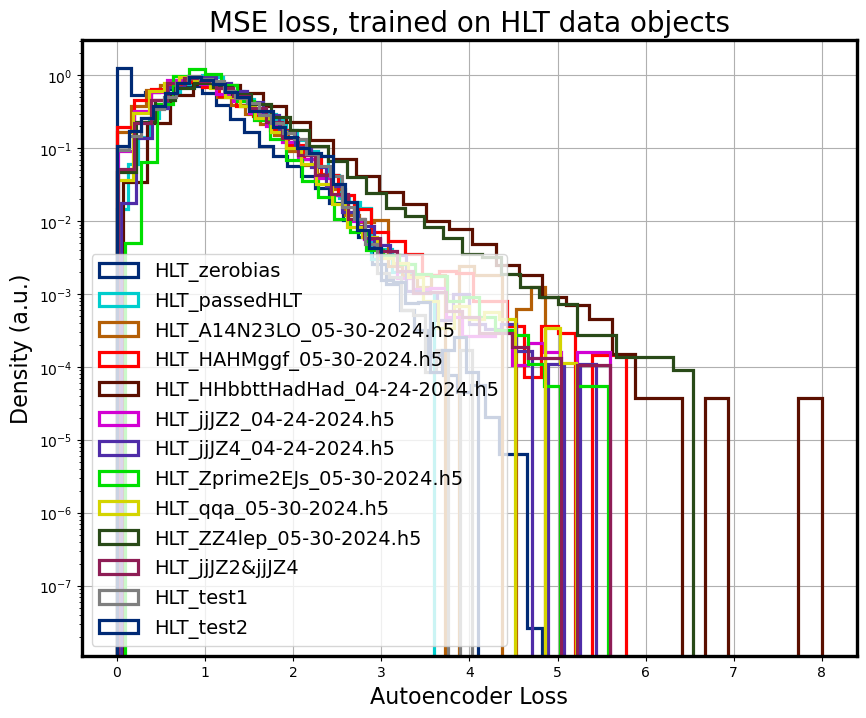

In [27]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, data in AD_scores.items():
    if tag.startswith('HLT'):
        plt.hist(data, bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights[tag])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on HLT data objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 1800x1000 with 0 Axes>

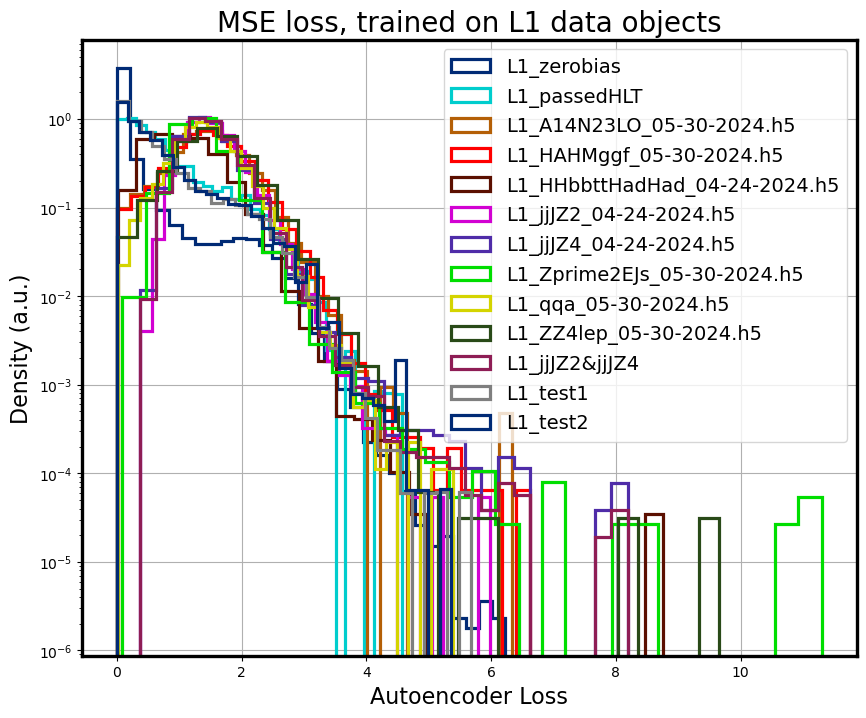

In [28]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, data in AD_scores.items():
    if tag.startswith('L1'):
        plt.hist(data, bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights[tag])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on L1 data objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

HLT_zerobias: TPR at FPR of 10^-4 is 0.00010 with threshold 3.3977
HLT_passedHLT: TPR at FPR of 10^-4 is 0.00026 with threshold 3.4332
HLT_A14N23LO_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00180 with threshold 3.3944
HLT_HAHMggf_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00199 with threshold 3.3977
HLT_HHbbttHadHad_04-24-2024.h5: TPR at FPR of 10^-4 is 0.00954 with threshold 3.3977
HLT_jjJZ2_04-24-2024.h5: TPR at FPR of 10^-4 is 0.00079 with threshold 3.3977
HLT_jjJZ4_04-24-2024.h5: TPR at FPR of 10^-4 is 0.00076 with threshold 3.4002
HLT_Zprime2EJs_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00119 with threshold 3.3977
HLT_qqa_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00076 with threshold 3.4031
HLT_ZZ4lep_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00662 with threshold 3.3977
HLT_jjJZ2&jjJZ4: TPR at FPR of 10^-4 is 0.00078 with threshold 3.3977
HLT_test2: TPR at FPR of 10^-4 is 0.00019 with threshold 3.3802


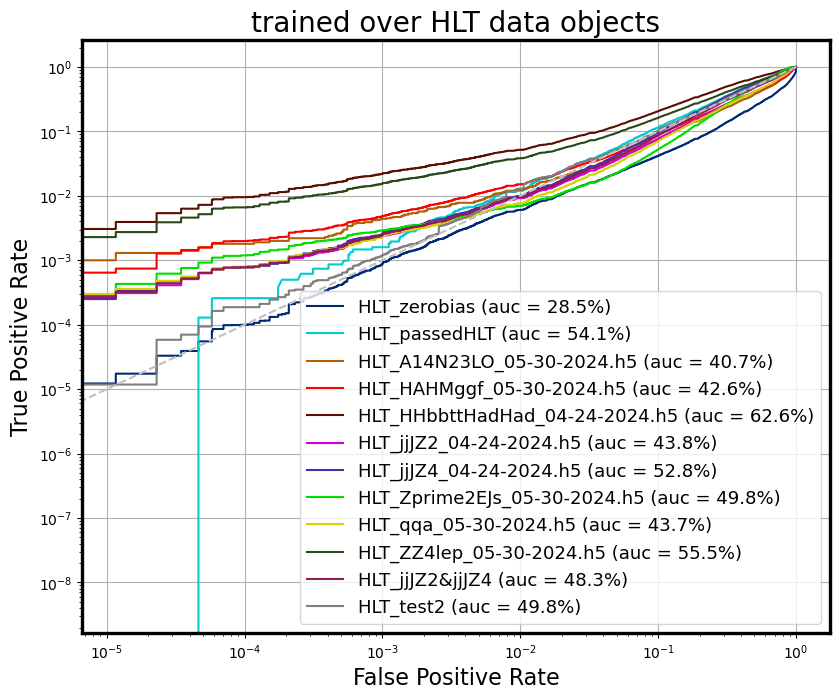

In [29]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['HLT_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

FPR = {}
TPR = {}
thresholds = {}

for tag in AD_scores.keys():
    if tag.startswith('HLT') and tag != 'HLT_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['HLT_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['HLT_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'HLT_test2': 
            HLT_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
        
        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over HLT data objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

L1_zerobias: TPR at FPR of 10^-4 is 0.00008 with threshold 4.1813
L1_passedHLT: TPR at FPR of 10^-4 is 0.00037 with threshold 4.1813
L1_A14N23LO_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00040 with threshold 4.1813
L1_HAHMggf_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00039 with threshold 4.1813
L1_HHbbttHadHad_04-24-2024.h5: TPR at FPR of 10^-4 is 0.00008 with threshold 4.1813
L1_jjJZ2_04-24-2024.h5: TPR at FPR of 10^-4 is 0.00013 with threshold 4.1813
L1_jjJZ4_04-24-2024.h5: TPR at FPR of 10^-4 is 0.00057 with threshold 4.1813
L1_Zprime2EJs_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00039 with threshold 4.1813
L1_qqa_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00014 with threshold 4.1813
L1_ZZ4lep_05-30-2024.h5: TPR at FPR of 10^-4 is 0.00034 with threshold 4.1813
L1_jjJZ2&jjJZ4: TPR at FPR of 10^-4 is 0.00035 with threshold 4.1813
L1_test2: TPR at FPR of 10^-4 is 0.00048 with threshold 4.1813


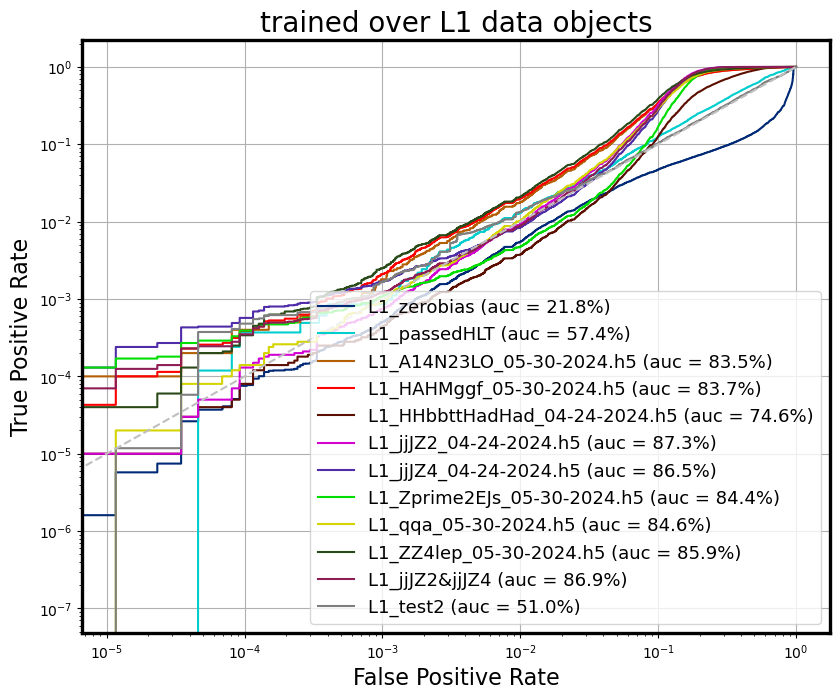

In [30]:
# Plot the L1 ROC curves

target_background = np.zeros(AD_scores['L1_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

for tag in AD_scores.keys():
    if tag.startswith('L1') and tag != 'L1_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['L1_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['L1_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'L1_test2': 
            L1_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value

        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")


# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over L1 data objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

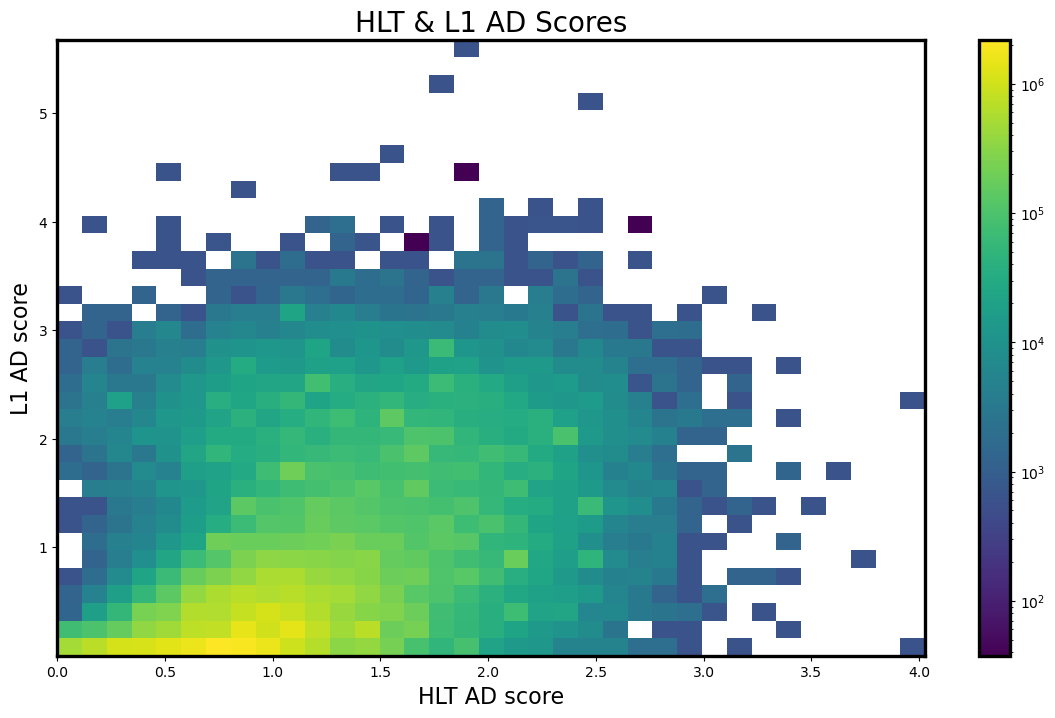

In [35]:
#2d hist of l1 vs hlt ad scores
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins=35

plt.hist2d(AD_scores['HLT_test1'], AD_scores['L1_test1'], bins=bins, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=weights['HLT_test1'])
plt.colorbar()
plt.title('HLT & L1 AD Scores', fontsize=20)
plt.xlabel(f'HLT AD score', fontsize=16)
plt.ylabel(f'L1 AD score', fontsize=16)
# plt.title(f'{data1_name} vs {data2_name} Leading {object} {var}', fontsize=18)
plt.show()

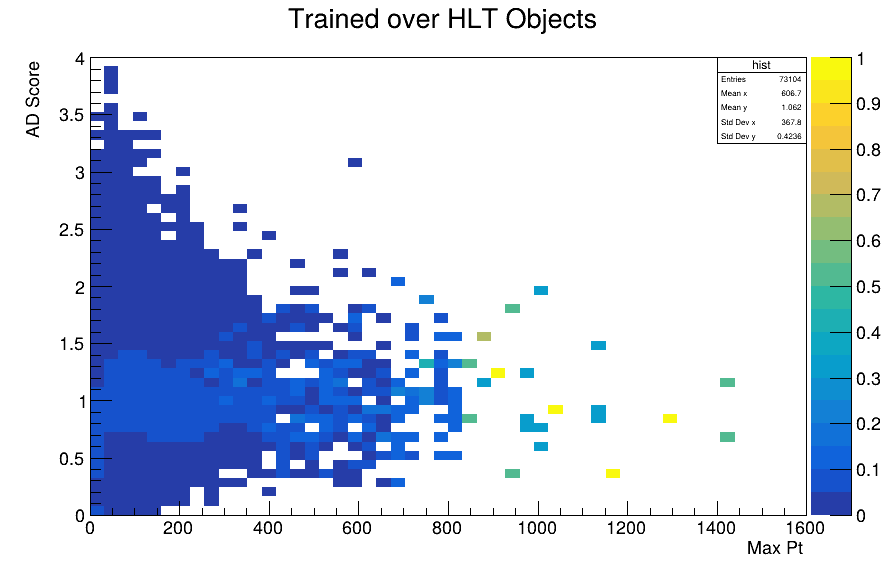

In [32]:
# create 2d histogram of ad scores and max pt using ROOT
var_HLT_1 = max_HLT_pt_vals
var_HLT_2 = AD_scores['HLT_test2']
var_L1_1 = max_HLT_pt_vals
var_L1_2 = AD_scores['L1_test2']
norm = 1
binsX = 100
binsY = 100
hist = ROOT.TH2F("hist", "Trained over HLT Objects", 50, 0, 1600, 50, 0, 4)

hist.SetXTitle("Max Pt")  
hist.SetYTitle("AD Score")  
 
norm = 1
binsX = 50   
binsY = 50   

for x, y in zip(var_HLT_1, var_HLT_2):
    hist.Fill(x, y)

for i in range(1, binsX + 1):
    num_events = 0.0
    for j in range(1, binsY + 1):
        bincont = hist.GetBinContent(i, j)
        num_events += bincont

    for j in range(1, binsY + 1):
        bincont = hist.GetBinContent(i, j)
        fact = norm / num_events if num_events != 0 else 0
        value = bincont * fact
        hist.SetBinContent(i, j, value)
 
ROOT.gStyle.SetStatX(0.9)  
ROOT.gStyle.SetStatY(0.9)   
ROOT.gStyle.SetStatW(0.1) 
ROOT.gStyle.SetStatH(0.1)  
HLT_root_canvas = ROOT.TCanvas("HLT_root_canvas", "HLT_root_canvas", 900, 600)
hist.Draw("COLZ")
HLT_root_canvas.Update()
HLT_root_canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


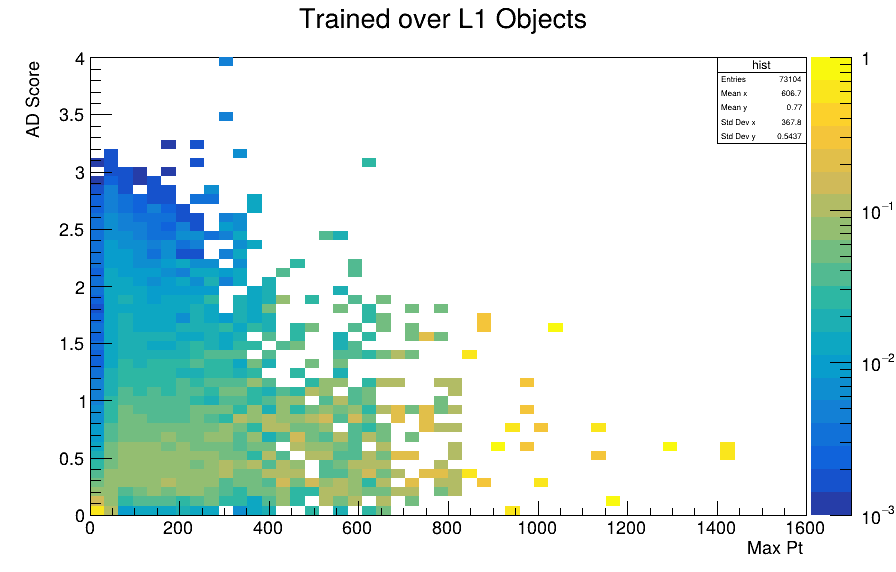

In [33]:
# Sample data: replace these with your actual NumPy arrays

# Create a 2D histogram
hist_L1 = ROOT.TH2F("hist", "Trained over L1 Objects", 50, 0, 1600, 50, 0, 4)

# Add axis titles
hist_L1.SetXTitle("Max Pt")  # Set the X axis title
hist_L1.SetYTitle("AD Score")  # Set the Y axis title

for x, y in zip(var_L1_1, var_L1_2):
    hist_L1.Fill(x, y)

for i in range(1, binsX + 1):
    num_events = 0.0
    for j in range(1, binsY + 1):
        bincont = hist_L1.GetBinContent(i, j)
        num_events += bincont

    for j in range(1, binsY + 1):
        bincont = hist_L1.GetBinContent(i, j)
        fact = norm / num_events if num_events != 0 else 0
        value = bincont * fact
        hist_L1.SetBinContent(i, j, value)
# Remove the statistics box

ROOT.gStyle.SetStatX(0.9)  # X position (0 to 1, from left to right)
ROOT.gStyle.SetStatY(0.9)  # Y position (0 to 1, from bottom to top)
ROOT.gStyle.SetStatW(0.1)  # Width of the stats box (fraction of canvas)
ROOT.gStyle.SetStatH(0.1)  # Height of the stats box (fraction of canvas)

# Create a canvas and draw the histogram
L1_root_canvas = ROOT.TCanvas("L1_root_canvas", "L1_root_canvas", 900, 600)
hist_L1.Draw("COLZ")
L1_root_canvas.SetLogz()
# Display the canvas
L1_root_canvas.Update()
L1_root_canvas.Draw()